In [27]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [28]:
import matplotlib as mpl
mpl.rcParams.update({'text.color' : 'black',
            'axes.labelcolor' : 'black','xtick.color': 'black','ytick.color': 'black'})

In [52]:
df = pd.read_csv('data/Bitcoin_data.csv')
df.head()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,1676939580000,2023-02-21 00:33:00,BTC/USD,24859.34,24859.34,24859.34,24859.34,0.000000,0.000000
1,1676939520000,2023-02-21 00:32:00,BTC/USD,24821.96,24859.34,24821.96,24859.34,0.103099,2562.977818
2,1676939460000,2023-02-21 00:31:00,BTC/USD,24818.09,24821.96,24815.47,24821.96,0.090640,2249.866178
3,1676939400000,2023-02-21 00:30:00,BTC/USD,24812.25,24818.09,24812.25,24818.09,0.002203,54.681450
4,1676939340000,2023-02-21 00:29:00,BTC/USD,24809.27,24812.25,24809.27,24812.25,0.090675,2249.862431


In [53]:
df = df.sort_values(by='Timestamp')
df['Date'] = pd.to_datetime(df['Date'],format= '%Y-%m-%d %H:%M:%S')
df = df.set_index('Date')

df.columns

Index(['Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume BTC',
       'Volume USD'],
      dtype='object')

## We will focus on Bitcoin High Price prediction

In [98]:
high_df = df.drop(['Timestamp','Symbol','Open','Low','Close','Volume BTC','Volume USD'],axis=1).copy()
high_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3766763 entries, 2015-10-08 13:40:00 to 2023-02-21 00:33:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   High    float64
dtypes: float64(1)
memory usage: 57.5 MB


<Axes: title={'center': 'Bitcoin High Price'}, xlabel='Date'>

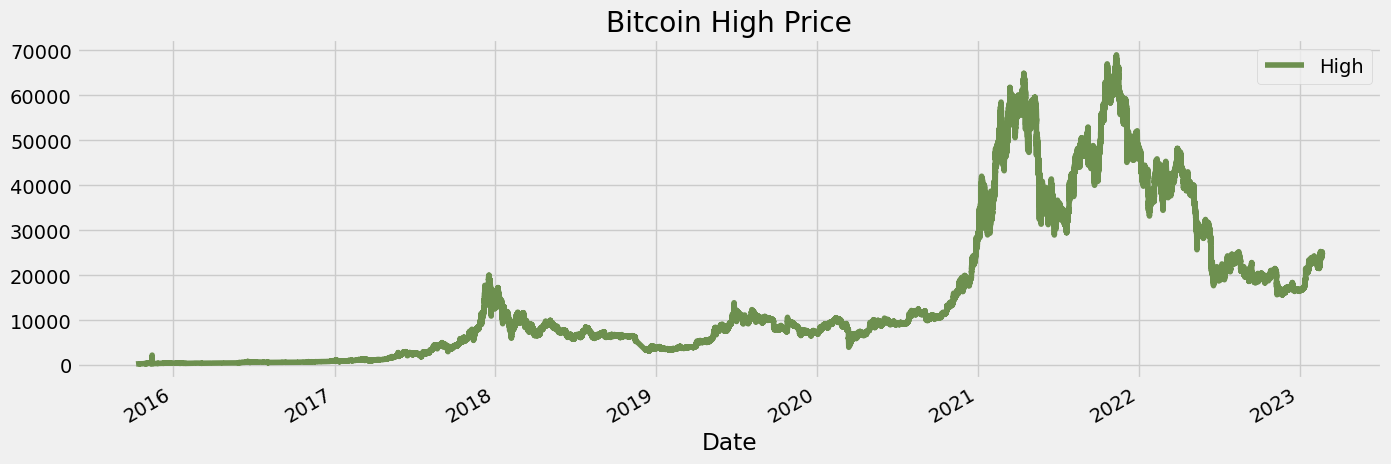

In [55]:
high_df.plot(style='-',figsize=(15,5),color=color_pal[3],title='Bitcoin High Price')

In [56]:
overall_duration = df.index.max() - df.index.min()
split_date = df.index.min() + 0.8 * overall_duration

print(f"Overall duration: {overall_duration}")
print(f"80% point: {split_date}")

Overall duration: 2692 days 10:53:00
80% point: 2021-08-31 12:46:24


In [57]:
train = high_df.loc[high_df.index < split_date]
test = high_df.loc[high_df.index >= split_date]

Text(0.5, 1.0, 'Bitcoin High Price Data Train/Test Split')

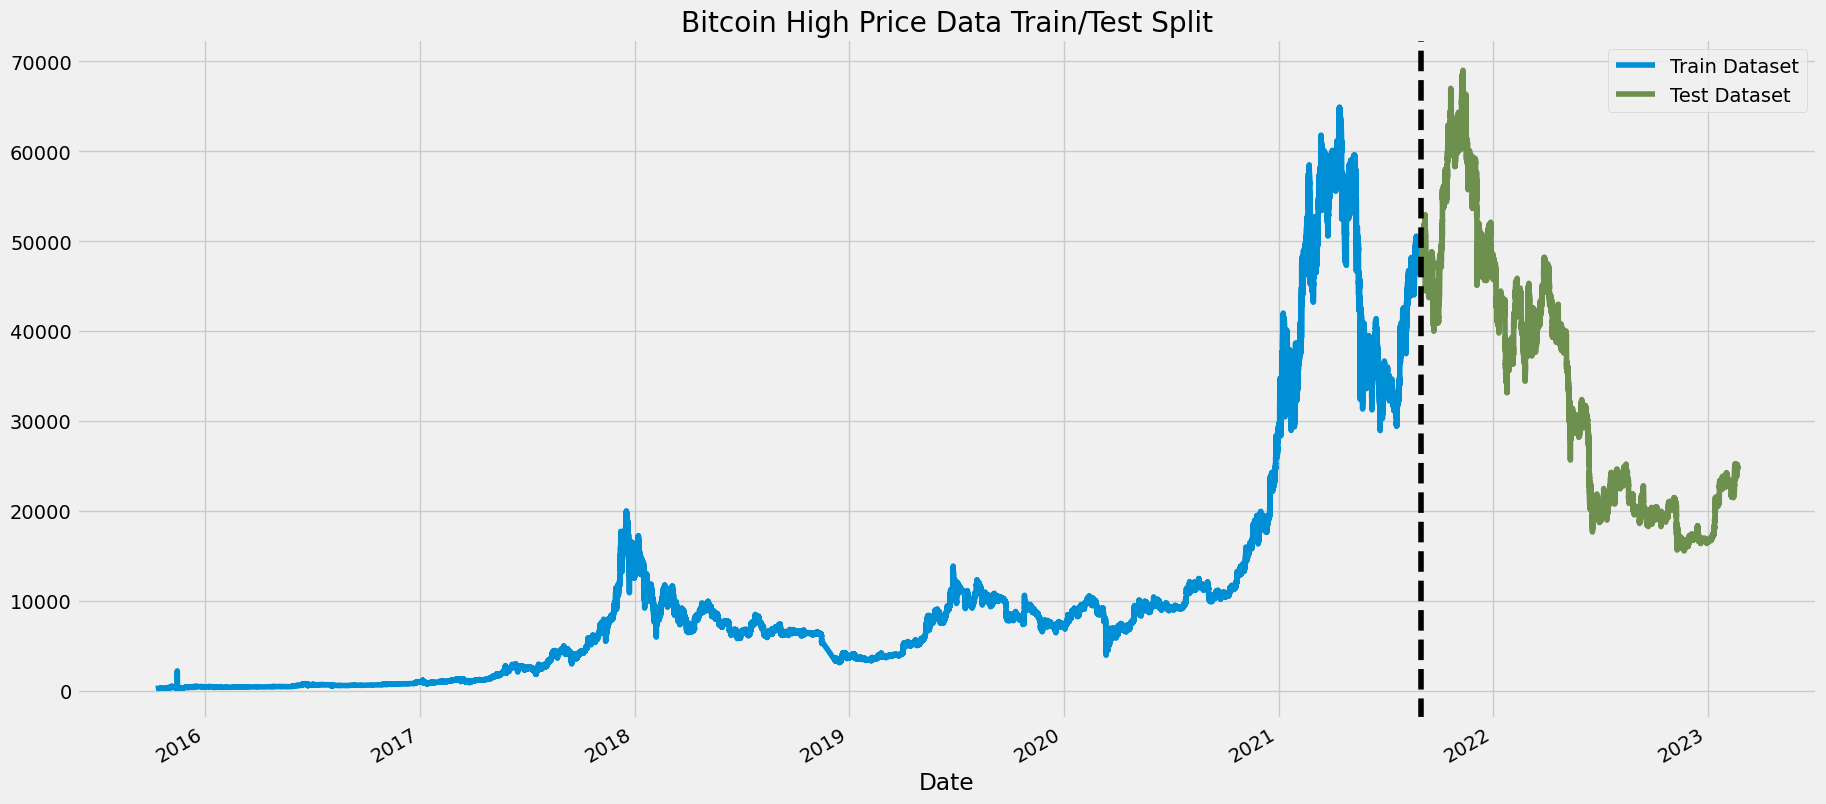

In [58]:
fig, ax = plt.subplots(figsize=(20,10))
train.plot(ax=ax, color=color_pal[0])
test.plot(ax=ax, color=color_pal[3])
ax.axvline('2021-08-31 12:46:24',color='black',ls='--')

ax.legend(['Train Dataset','Test Dataset'])
plt.title('Bitcoin High Price Data Train/Test Split')

<Axes: xlabel='Date'>

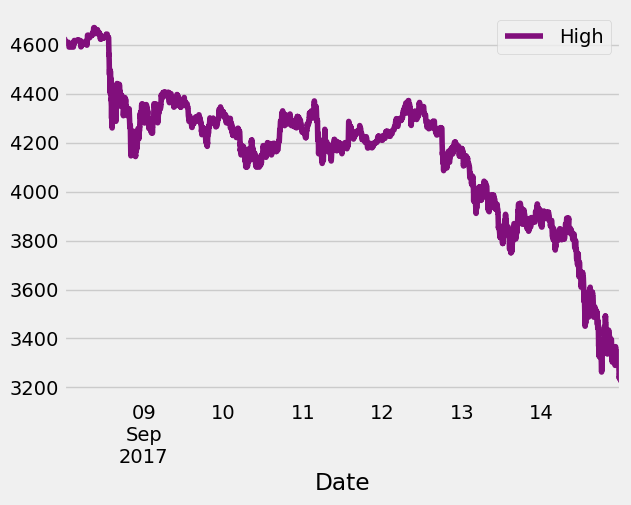

In [59]:
high_df.loc[(high_df.index > '2017-09-08') & (high_df.index < '2017-09-15')].plot(color= color_pal[5])

In [68]:
def time_features(df):
    '''Create a time series features based on time-series index.'''
    df_time = df.copy()
    df_time['hour'] = df_time.index.hour
    df_time['dayofweek'] = df_time.index.dayofweek
    df_time['quarter'] = df_time.index.quarter
    df_time['month'] = df_time.index.month
    df_time['year'] = df_time.index.year
    df_time['dayofyear'] = df_time.index.dayofyear
    return df_time

df_time = time_features(high_df)

In [69]:
df_time.head()

,High,hour,dayofweek,quarter,month,year,dayofyear
Date,,,,,,,
2015-10-08 13:40:00,242.50,13,3,4,10,2015,281
2015-10-08 13:41:00,242.95,13,3,4,10,2015,281
2015-10-08 13:42:00,242.95,13,3,4,10,2015,281
2015-10-08 13:43:00,242.96,13,3,4,10,2015,281
2015-10-08 13:44:00,242.96,13,3,4,10,2015,281


Text(0.5, 0, 'Interval')

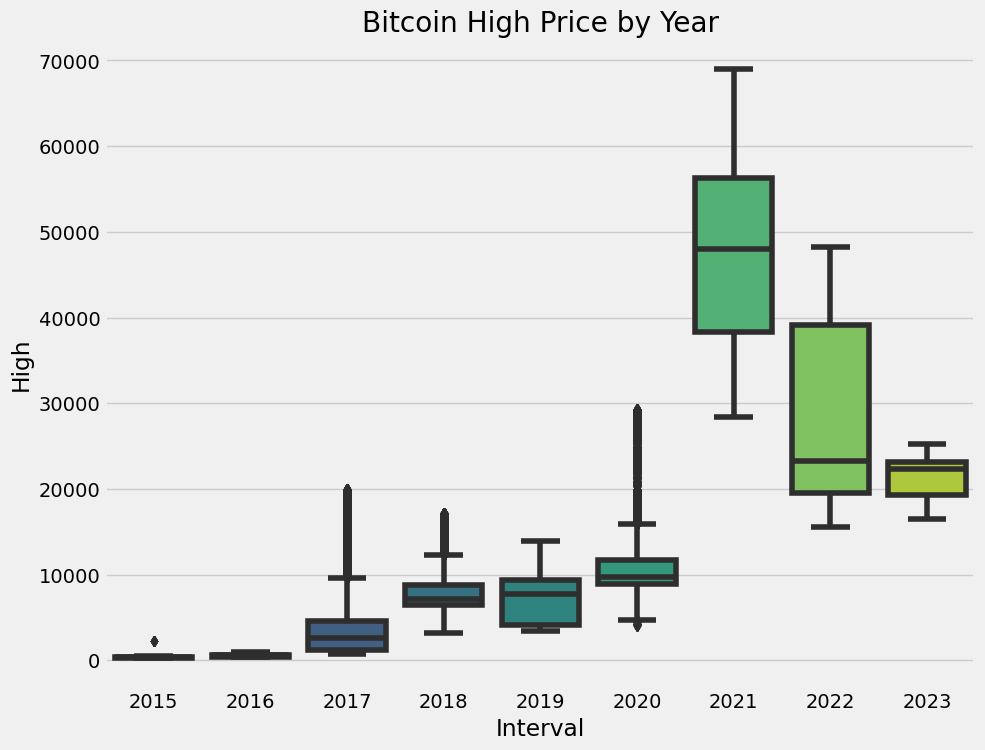

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df_time,x='year',y='High',palette='viridis')
ax.set_title('Bitcoin High Price by Year')
ax.set_xlabel('Interval')


Text(0.5, 0, 'Interval')

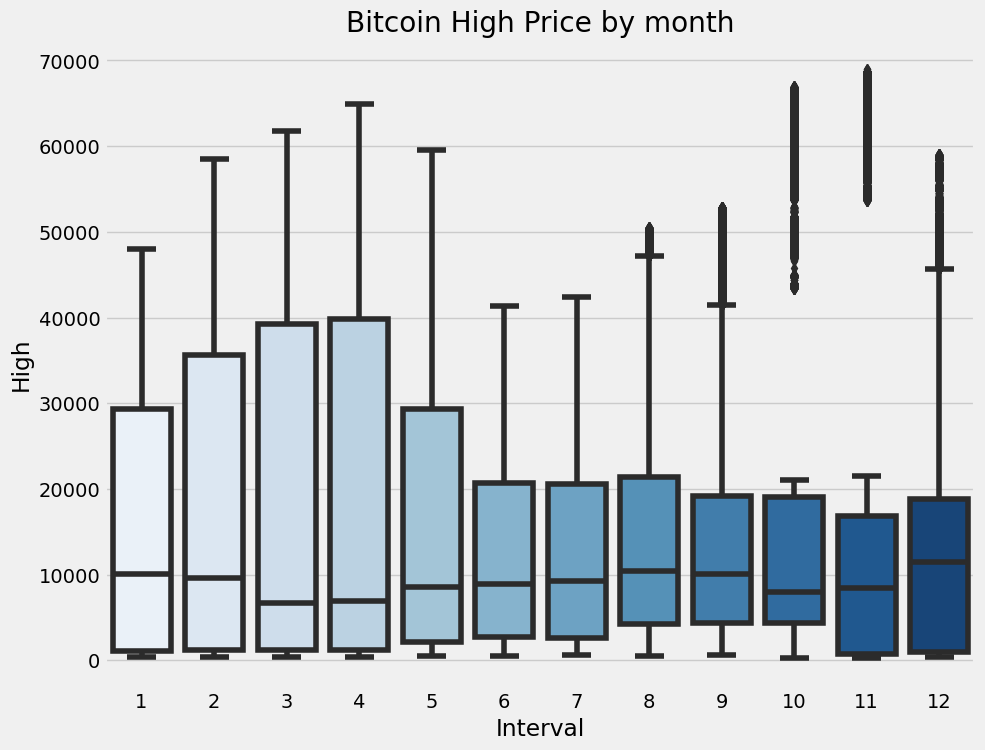

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df_time,x='month',y='High',palette='Blues')
ax.set_title('Bitcoin High Price by month')
ax.set_xlabel('Interval')

In [85]:
# Should update the train and test dataset with the new time series features
train = time_features(train)
test = time_features(test)

# List the features and targets
features = ['month','year','dayofyear']
target = 'High'

# From the split of train test dataframe, further divide the dataset by the features and targets
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Using XGBoost to Predict Target Variable

In [94]:
model1 = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds = 100)
model1.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)], verbose = 100)

[0]	validation_0-rmse:11910.06992	validation_1-rmse:24106.67863
[100]	validation_0-rmse:312.68693	validation_1-rmse:18343.54750
[102]	validation_0-rmse:311.86465	validation_1-rmse:18343.79035


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [95]:
fi = pd.DataFrame(data=model1.feature_importances_,
index=model1.feature_names_in_,columns=['Importance'])

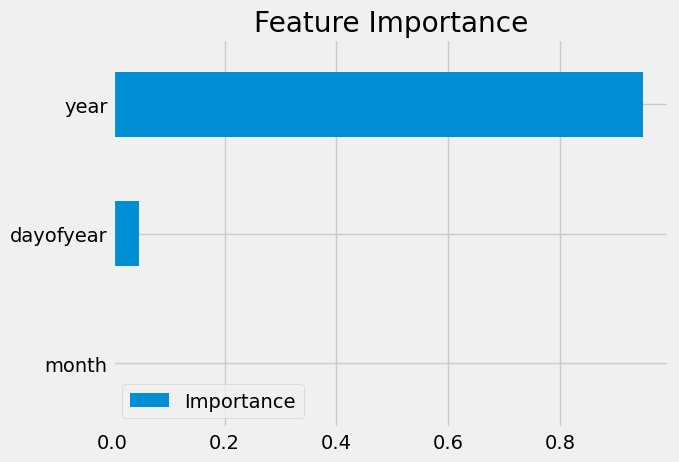

In [96]:
fi.sort_values('Importance').plot(kind='barh',title='Feature Importance')
plt.show()

In [99]:
test['xgb_pred'] = model1.predict(X_test)

high_df = high_df.merge(test[['xgb_pred']],how='left',left_index=True,right_index=True).copy()
high_df.head()

,High,xgb_pred
Date,,
2015-10-08 13:40:00,242.50,NaN
2015-10-08 13:41:00,242.95,NaN
2015-10-08 13:42:00,242.95,NaN
2015-10-08 13:43:00,242.96,NaN
2015-10-08 13:44:00,242.96,NaN


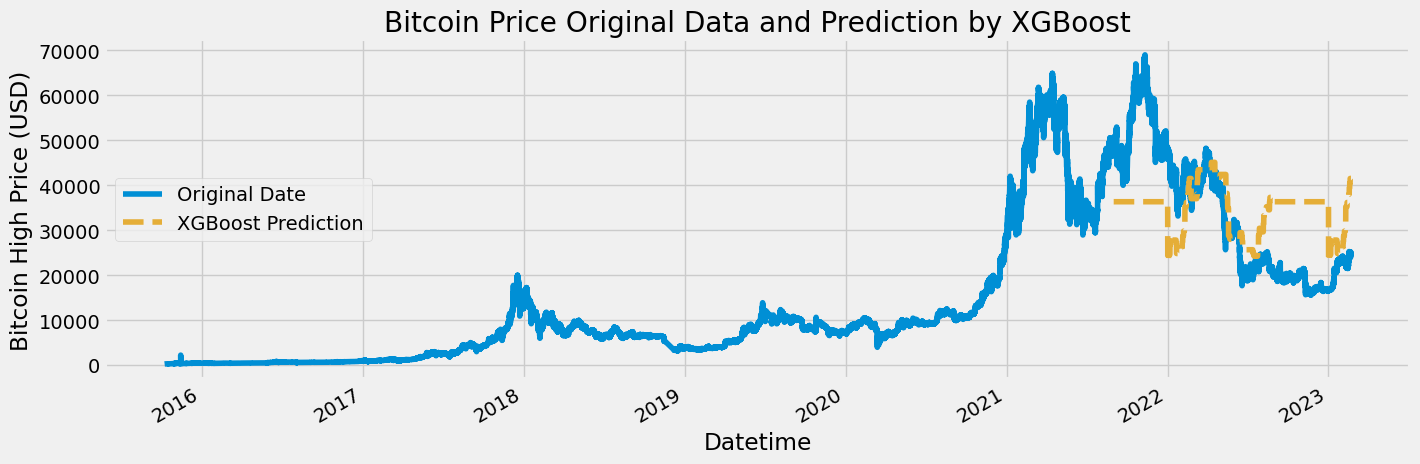

In [101]:
ax = high_df[['High']].plot(figsize=(15,5),color=color_pal[0])
high_df['xgb_pred'].plot(ax=ax,style='--',color=color_pal[2])
ax.legend(['Original Date','XGBoost Prediction'],loc='center left')
ax.set_title('Bitcoin Price Original Data and Prediction by XGBoost')
ax.set_xlabel('Datetime')
ax.set_ylabel('Bitcoin High Price (USD)')
plt.show()